In [ ]:
import matplotlib.pyplot as plt
import random
import torch
import tqdm
import os

In [ ]:
INPUT_FILE = "input.txt"
MODEL_DIR = "model"
MODEL_FILE = "embeddings_MLP.pt"

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

# hyperparameters
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
BATCH_SIZE = 64
CONTEXT_SIZE = 5
EMBEDDING_DIM = 10
N_NEURONS = 100
LEARNING_RATE = 0.1
N_EPOCHS = 5
LR_DECAY_FREQ = 2
LR_DECAY_FACTOR = 0.1

In [77]:
def read_input() -> list[str]:
    """
    Read words from INPUT_FILE.

    Returns:
        words (list[str]): A list of words read from the input file.
    """
    with open(INPUT_FILE) as f:
        words = f.read().splitlines()
    print(f"read {len(words)} words from {INPUT_FILE}")
    return words

In [78]:
def creat_vocab_and_tokenize(
        words: list[str]
    ) -> tuple[list[str], dict[str, int], dict[int, str], list[list[int]]]:
    """
    Create a vocabulary and tokenize the input words.

    Args:
        words (list[str]): A list of words to tokenize.

    Returns:
        vocab (list[str]): A sorted list of unique tokens in the input words.
        token_to_index (dict[str, int]): A dictionary mapping tokens to their indices.
        index_to_token (dict[int, str]): A dictionary mapping indices to their corresponding tokens.
        tokenized_words (list[list[int]]): A list of tokenized words, where each word is represented as a list of token indices.
    """
    vocab = sorted(set("".join(words)))
    vocab.extend(["."])
    token_to_index = {token: index for index, token in enumerate(vocab)}
    index_to_token = {index: token for index, token in enumerate(vocab)}
    tokenized_words = [[token_to_index[token] for token in word] for word in words]
    print(f"created vocab of size {len(vocab)}")
    return vocab, token_to_index, index_to_token, tokenized_words

In [79]:
def make_dataset(
        tokenized_words: list[list[int]], 
        token_to_index: dict[str, int]
    ) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Create a dataset from tokenized words.

    Args:
        tokenized_words (list[list[int]]): A list of tokenized words, where each word is represented as a list of token indices.
        token_to_index (dict[str, int]): A dictionary mapping tokens to their indices.

    Returns:
        X (torch.Tensor): A tensor representing the input contexts.
        Y (torch.Tensor): A tensor representing the corresponding output tokens.
    """
    X, Y = [], []
    for tokenized_word in tokenized_words:
        context = [token_to_index["."]] * CONTEXT_SIZE
        for token in tokenized_word+[token_to_index["."]]:
            X.append(context)
            Y.append(token)
            context = context[1:] + [token]
    return torch.tensor(X), torch.tensor(Y)

In [80]:
def split_data(
        tokenized_words: list[list[int]],
        token_to_index: dict[str, int]
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Split the tokenized words into training, validation, and testing datasets.

    Args:
        tokenized_words (list[list[int]]): A list of tokenized words, where each word is represented as a list of token indices.
        token_to_index (dict[str, int]): A dictionary mapping tokens to their indices.

    Returns:
        X_train (torch.Tensor): A tensor representing the input contexts for training.
        Y_train (torch.Tensor): A tensor representing the corresponding output tokens for training.
        X_val (torch.Tensor): A tensor representing the input contexts for validation.
        Y_val (torch.Tensor): A tensor representing the corresponding output tokens for validation.
        X_test (torch.Tensor): A tensor representing the input contexts for testing.
        Y_test (torch.Tensor): A tensor representing the corresponding output tokens for testing.
    """
    random.shuffle(tokenized_words)
    n_words = len(tokenized_words)
    X_train, Y_train = make_dataset(tokenized_words[:int(TRAIN_RATIO*n_words)], token_to_index)
    print(f"created training set with{X_train.shape[0]} examples")
    X_val, Y_val = make_dataset(tokenized_words[int(TRAIN_RATIO*n_words):int((TRAIN_RATIO+VAL_RATIO)*n_words)], token_to_index)
    print(f"created validation set with {X_val.shape[0]} examples")
    X_test, Y_test = make_dataset(tokenized_words[int((TRAIN_RATIO+VAL_RATIO)*n_words):], token_to_index)
    print(f"created testing set with {X_test.shape[0]} examples")
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [81]:
def initialize_model(
        vocab: list[str]
    ) -> tuple[torch.Tensor]:
    """
    Initialize a neural network model.

    Args:
        vocab (list[str]): A list of unique tokens in the input words.

    Returns:
        model (tuple[torch.Tensor]): A tuple containing the model's parameters.
    """
    embeddings = torch.randn((len(vocab), EMBEDDING_DIM))
    w1 = torch.randn((CONTEXT_SIZE * EMBEDDING_DIM, N_NEURONS))
    torch.nn.init.kaiming_normal_(w1.data, nonlinearity="tanh")
    b1 = torch.zeros(N_NEURONS)
    ln1gain = torch.ones((1, N_NEURONS))
    ln1bias = torch.zeros((1, N_NEURONS))
    w2 = torch.randn((N_NEURONS, N_NEURONS))
    torch.nn.init.kaiming_normal_(w2.data, nonlinearity="tanh")
    b2 = torch.zeros(N_NEURONS)
    ln2gain = torch.ones((1, N_NEURONS))
    ln2bias = torch.zeros((1, N_NEURONS))
    w3 = torch.randn((N_NEURONS, N_NEURONS))
    torch.nn.init.kaiming_normal_(w3.data, nonlinearity="tanh")
    b3 = torch.zeros(N_NEURONS)
    ln3gain = torch.ones((1, N_NEURONS))
    ln3bias = torch.zeros((1, N_NEURONS))
    w4 = torch.randn((N_NEURONS, len(vocab))) * 0.1
    torch.nn.init.kaiming_normal_(w4.data, nonlinearity="tanh")
    b4 = torch.zeros(len(vocab))

    model = (
        embeddings, 
        w1, 
        b1, 
        ln1gain, 
        ln1bias, 
        w2, 
        b2,
        ln2gain, 
        ln2bias, 
        w3, 
        b3,
        ln3gain, 
        ln3bias, 
        w4, 
        b4
    )
    for p in model:
        p.requires_grad = True

    print(f"initialize model with {sum(p.numel() for p in model)} parameters")
    return model

In [ ]:
def train_model(
        model: tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor], 
        X_train: torch.Tensor, 
        Y_train: torch.Tensor, 
        X_val: torch.Tensor, 
        Y_val: torch.Tensor
    ) -> None:
    """
    Train a neural network model.

    Args:
        model (tuple[torch.Tensor]): A tuple containing the model's parameters.
        X_train (torch.Tensor): A tensor representing the input contexts for training.
        Y_train (torch.Tensor): A tensor representing the corresponding output tokens for training.
        X_val (torch.Tensor): A tensor representing the input contexts for validation.
        Y_val (torch.Tensor): A tensor representing the corresponding output tokens for validation.

    Returns:
        None
    """
    embeddings, w1, b1, ln1gain, ln1bias, w2, b2,ln2gain, ln2bias, w3, b3,ln3gain, ln3bias, w4, b4 = model
    n_optimizations = 0
    update_to_data_ratios = []
    log_every = 100
    train_losses = [] # train log losses
    val_losses_i = []
    val_losses = [] # val log losses
    min_val_loss = float("inf")

    print("training model...")

    current_learning_rate = LEARNING_RATE
    for i in tqdm.tqdm(range(N_EPOCHS)):

        # decay learning rate
        if i > 0 and i % LR_DECAY_FREQ == 0:
            current_learning_rate *= LR_DECAY_FACTOR

        # shuffle data
        shuffled_indices = torch.randperm(X_train.shape[0])
        X_train = X_train[shuffled_indices]
        Y_train = Y_train[shuffled_indices]

        for b in range(0, len(X_train), BATCH_SIZE):

            # forward pass
            embedding = embeddings[X_train[b:b+BATCH_SIZE]].view(-1, CONTEXT_SIZE * EMBEDDING_DIM)
            h1 = embedding @ w1 + b1
            ln1 = ln1gain * (h1 - h1.mean(dim=1, keepdim=True)) / h1.std(dim=1, keepdim=True) + ln1bias
            layer1 = torch.tanh(ln1)

            h2 = layer1 @ w2 + b2
            ln2 = ln2gain * (h2 - h2.mean(dim=1, keepdim=True)) / h2.std(dim=1, keepdim=True) + ln2bias
            layer2 = torch.tanh(ln2)

            h3 = layer2 @ w3 + b3
            ln3 = ln3gain * (h3 - h3.mean(dim=1, keepdim=True)) / h3.std(dim=1, keepdim=True) + ln3bias
            layer3 = torch.tanh(ln3)

            h4 = layer3 @ w4 + b4
            loss = torch.nn.functional.cross_entropy(h4, Y_train[b:b+BATCH_SIZE])

            train_losses.append(loss.item())

            # backward pass
            for p in model:
                p.grad = None
            loss.backward()

            # update
            for p in model:
                p.data += -current_learning_rate * p.grad

            with torch.no_grad():
                update_to_data_ratios.append([((current_learning_rate*p.grad).std() / p.data.std()).log10().item() for p in model])

            # log val loss
            if  n_optimizations == 0 or n_optimizations % log_every == 0 or n_optimizations == len(X_train) // BATCH_SIZE - 1:
                with torch.no_grad():
                    embedding = embeddings[X_val].view(-1, CONTEXT_SIZE * EMBEDDING_DIM)
                    h1 = embedding @ w1 + b1
                    ln1 = ln1gain * (h1 - h1.mean(dim=1, keepdim=True)) / h1.std(dim=1, keepdim=True) + ln1bias
                    layer1 = torch.tanh(ln1)

                    h2 = layer1 @ w2 + b2
                    ln2 = ln2gain * (h2 - h2.mean(dim=1, keepdim=True)) / h2.std(dim=1, keepdim=True) + ln2bias
                    layer2 = torch.tanh(ln2)

                    h3 = layer2 @ w3 + b3
                    ln3 = ln3gain * (h3 - h3.mean(dim=1, keepdim=True)) / h3.std(dim=1, keepdim=True) + ln3bias
                    layer3 = torch.tanh(ln3)

                    h4 = layer3 @ w4 + b4
                    val_losses.append(torch.nn.functional.cross_entropy(h4, Y_val).item())
                    val_losses_i.append(n_optimizations)

            n_optimizations += 1

            # save best model
            if val_losses[-1] < min_val_loss:
                min_val_loss = val_losses[-1]
                torch.save(os.path.join(MODEL_DIR, MODEL_FILE))


        print(f"epoch {i+1}, val loss {10**val_losses[-1]:.3f} with learning rate {current_learning_rate:.3f}")

    print(f"model training complete with min val loss: {10**min_val_loss:.3f}")
    print(f"saved model to {MODEL_DIR}")
    running_avg = 100
    train_losses_i = [i for i in range(0, len(train_losses), running_avg)]
    train_losses = torch.tensor(train_losses + [float("nan")] * ((running_avg - len(train_losses) % running_avg) % running_avg)).view(-1, running_avg).mean(dim=1)
    plt.plot(train_losses_i, train_losses, label="train loss")
    plt.plot(val_losses_i, val_losses, label="val loss")
    plt.xlabel("optimization")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(20, 4))
    legends = []
    for i, p in enumerate(model):
        if p.ndim == 2: # only linear layers
            plt.plot([update_to_data_ratios[j][i] for j in range(len(update_to_data_ratios))])
            legends.append(f"param {i}")
    plt.plot([0, len(update_to_data_ratios)], [-3, -3], "k") # these ratios should be ~1e-3, indicate on plot
    plt.legend(legends)
    plt.show()

read 32033 words from input.txt
created vocab of size 27
created training set with182638 examples
created validation set with 22692 examples
created testing set with 22816 examples
initialize model with 28897 parameters
training model...


 20%|██        | 1/5 [00:14<00:58, 14.50s/it]

epoch 1, val loss 175.377 with learning rate 0.100


 40%|████      | 2/5 [00:29<00:45, 15.04s/it]

epoch 2, val loss 156.022 with learning rate 0.100


 60%|██████    | 3/5 [00:46<00:31, 15.66s/it]

epoch 3, val loss 138.872 with learning rate 0.010


 80%|████████  | 4/5 [01:04<00:16, 16.55s/it]

epoch 4, val loss 137.189 with learning rate 0.010


100%|██████████| 5/5 [01:20<00:00, 16.18s/it]

epoch 5, val loss 136.240 with learning rate 0.001
model training complete with min val loss: 136.214
saved model to model


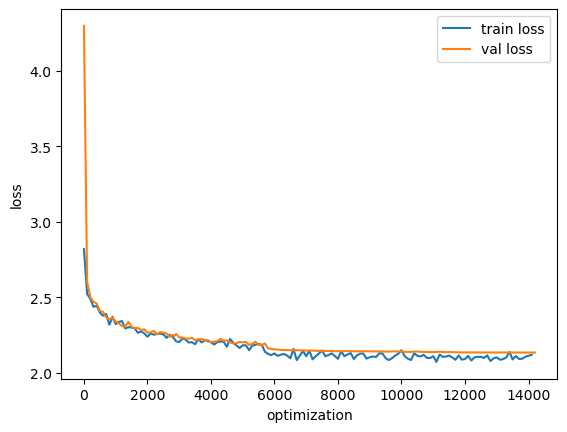

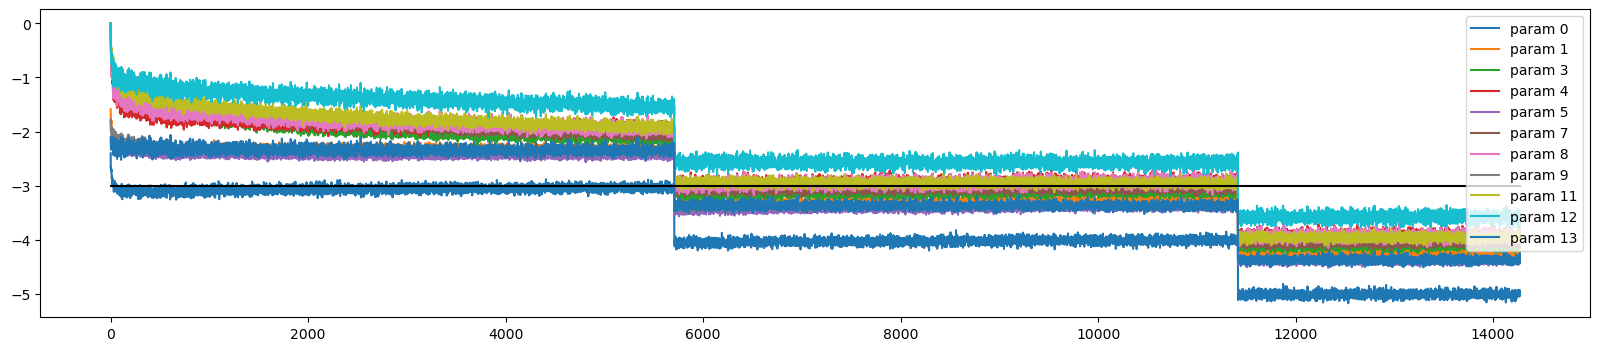

In [209]:
words = read_input()
vocab, token_to_index, index_to_token, tokenized_words = creat_vocab_and_tokenize(words)
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data(tokenized_words, token_to_index)
model = initialize_model(vocab)
train_model(model, X_train, Y_train, X_val, Y_val)

In [210]:
def infer_word(
        model: tuple[torch.Tensor], 
        words: list[str], 
        token_to_index: dict[str, int], 
        index_to_token: dict[int, str]
    ) -> str:
    """
    Infer a word using a trained neural network model.

    Args:
        model (tuple[torch.Tensor]): A tuple containing the model's parameters.
        words (list[str]): A list of words to infer from.
        token_to_index (dict[str, int]): A dictionary mapping tokens to their indices.
        index_to_token (dict[int, str]): A dictionary mapping indices to their corresponding tokens.

    Returns:
        word (str): The inferred word.
    """
    embeddings, w1, b1, ln1gain, ln1bias, w2, b2,ln2gain, ln2bias, w3, b3,ln3gain, ln3bias, w4, b4 = model
    context = [token_to_index["."]] * CONTEXT_SIZE
    while True:
        word = ""
        while True:
            with torch.no_grad():
                embedding = embeddings[context].view(-1, CONTEXT_SIZE * EMBEDDING_DIM)
                h1 = embedding @ w1 + b1
                ln1 = ln1gain * (h1 - h1.mean(dim=1, keepdim=True)) / h1.std(dim=1, keepdim=True) + ln1bias
                layer1 = torch.tanh(ln1)

                h2 = layer1 @ w2 + b2
                ln2 = ln2gain * (h2 - h2.mean(dim=1, keepdim=True)) / h2.std(dim=1, keepdim=True) + ln2bias
                layer2 = torch.tanh(ln2)

                h3 = layer2 @ w3 + b3
                ln3 = ln3gain * (h3 - h3.mean(dim=1, keepdim=True)) / h3.std(dim=1, keepdim=True) + ln3bias
                layer3 = torch.tanh(ln3)

                h4 = layer3 @ w4 + b4
                probabilities = torch.nn.functional.softmax(h4, dim=1)
                index = torch.multinomial(probabilities, num_samples=1)[0].item()

            if index == token_to_index["."]:
                break
            context = context[1:] + [index]
            word += index_to_token[index]

        if word and word not in words:
            break
        
    return word

In [ ]:
model = torch.load(os.path.join(MODEL_DIR, MODEL_FILE), weights_only=True)

In [213]:
for i in range(10):
    print(infer_word(model, words, token_to_index, index_to_token))

staryn
brnick
millah
courzlyn
kalliano
kelle
corpon
derillynn
agemeson
duzea
